# ResNet-50: CIFAR-10

- Trained with Swish activation function: $f(x) = \frac{x}{1 + e^{-\beta \cdot x}}$, where $\beta$ is a trainable hyper-parameter. Or, $f(x) = x \cdot sigmoid(\beta \cdot x)$.
- Linear learning-rate warmup, followed by step-decays.

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
'''
Specify GPU(s) to be used here. Say you have 6 GPUs and you want to train Model A on 2 of them
and Model B on 4 of them. You can do that as follows-
CUDA_VISIBLE_DEVICES=0,1 python model_A.py
CUDA_VISIBLE_DEVICES=2,3,4,5 python model_B.py
'''
# %env CUDA_VISIBLE_DEVICES = 0, 1, 2, 3
%env CUDA_VISIBLE_DEVICES = 0, 1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0, 1


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from resnet_bottleneck_block import resnet_block, ResNet50
from cifar10_dataloader import get_cifar10_data
from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import numpy as np
import os, pickle

In [3]:
print(f"torch version: {torch.__version__}")


# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

torch version: 1.13.1
Number of GPU(s) available = 2
Current GPU: 0
Current GPU name: NVIDIA TITAN RTX
Available device is cuda


In [4]:
# Specify hyper-parameters
batch_size = 256
num_classes = 10
num_epochs = 85

In [5]:
# Get CIFAR-10 dataset-
train_loader, val_loader, train_dataset, val_dataset = get_cifar10_data(
    path_to_files = '/home/majumdar/Downloads/.data/',
    batch_size = 256
)

Files already downloaded and verified
Files already downloaded and verified


#### ResNet-50 + $\beta$ parameter (Swish) from initial experiment

A previous experiment found that the optimal $\beta = 5.354$ gave the highest validation accuracy. So, a new ResNet-50 is initialized with this $\beta$ value and retrained from scratch to compare the benefits of initializing the same network with the previously obtained optimal value.

In [6]:
# Instantiate ResNet-50 CNN-
model = ResNet50(beta = 5.354).to(device)

In [7]:
# Sanity check-
print(f"beta is initialized as:{model.swish_fn.beta.detach().item():.4f}")

beta is initialized as:5.3540


In [8]:
def count_trainable_params(model):
    # Count number of layer-wise parameters and total parameters-
    tot_params = 0
    for param in model.parameters():
        # print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
        tot_params += param.nelement()

    return tot_params


In [9]:
print(f"ResNet-50 CNN has {count_trainable_params(model)} params")

ResNet-50 CNN has 23520843 params


In [10]:
# Define loss function and optimizer-
loss = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    params = model.parameters(), lr = 0.0,
    momentum = 0.9, weight_decay = 5e-4
)

#### Train model with learning rate scheduler

Training dataset = 50000, batch size = 256, number of training steps/iterations per epoch = 50000 / 256 = 195.3125 = 195

After an initial linear learning rate warmup of 13 epochs or 2539 training steps:

- For the next 7 epochs, or, until $20^{th}$ epoch, use lr = 0.1.

- For the next 25 epochs, or, until $45^{th}$ epoch, use lr = 0.01.

- For the 25 epochs, or, until $70^{th}$ epoch, use lr = 0.001.

- For remaining epochs (10 epochs), use lr = 0.0001.

In [11]:
boundaries = [3906, 8790, 13672]
values = [0.1, 0.01, 0.001, 0.0001]

In [12]:
def decay_function(
    step, boundaries = [3906, 8790, 13672],
    values = [0.1, 0.01, 0.001, 0.0001]
):    
    for idx, bound in enumerate(boundaries):
        if step < bound:
            return values[idx]

    return values[-1]

class schedule():

    def __init__(self, initial_learning_rate = 0.1, warmup_steps = 1000, decay_func = None):
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.decay_func = decay_func
        self.warmup_step_size = initial_learning_rate/warmup_steps
        self.current_lr = 0

    def get_lr(self, step):
        if step == 0:
            return self.current_lr
        elif step <= self.warmup_steps:
            self.current_lr+= self.warmup_step_size
            return self.current_lr
        elif step > self.warmup_steps:
            if self.decay_func:
                return self.decay_func(step)
        else:
            return self.current_lr
        

In [13]:
# Initial linear LR warmup: 195.3125 x 13 = 2549 steps in 13 epochs.
custom_lr_scheduler = schedule(
    initial_learning_rate = 0.1, warmup_steps = 2539,
    decay_func = decay_function
)

In [14]:
step = 0

In [15]:
def train_model_progress(model, train_loader, train_dataset):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0
    
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = loss(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            global step
            optimizer.param_groups[0]['lr'] = custom_lr_scheduler.get_lr(step)

            step += 1
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.cpu().numpy()

def test_model_progress(model, test_loader, test_dataset):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                
                # Set model to evaluation mode-
                model.eval()
            
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.cpu().numpy()


In [16]:
# Python3 dict to contain training metrics-
training_history_lr_scheduler = {}

# Initialize parameters saving 'best' models-
best_val_acc = 50

In [17]:
for epoch in range(num_epochs):

    # Train and validate model for 1 epoch-
    train_loss, train_acc = train_model_progress(
        model = model, train_loader = train_loader,
        train_dataset = train_dataset
    )
    val_loss, val_acc = test_model_progress(
        model = model, test_loader = val_loader,
        test_dataset = val_dataset
    )
    
    curr_lr = optimizer.param_groups[0]['lr']
    curr_beta = model.swish_fn.beta.detach().item()
    
    print(f"\nepoch: {epoch + 1} training loss = {train_loss:.4f}, "
          f"training accuracy = {train_acc:.2f}%, val_loss = {val_loss:.4f}"
          f", val_accuracy = {val_acc:.2f}% "
          f"LR = {curr_lr:.4f} & beta = {curr_beta:.6f}\n")
    
    training_history_lr_scheduler[epoch + 1] = {
        'loss': train_loss, 'acc': train_acc,
        'val_loss': val_loss, 'val_acc': val_acc,
        'lr': curr_lr, 'beta': curr_beta
    }
    
    # Save best weights achieved until now-
    if (val_acc > best_val_acc):
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_acc = val_acc

        print(f"Saving model with highest val acc = {val_acc:.4f}%\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "ResNet50_best_valacc_model.pth")
        

Validation: : 100%|█████████████████████████████████| 40/40 [00:04<00:00,  9.40batch/s, val_acc=21.7, val_loss=2.33]



epoch: 1 training loss = 2.2529, training accuracy = 15.61%, val_loss = 2.3296, val_accuracy = 21.66% LR = 0.0077 & beta = 5.323336



Validation: : 100%|█████████████████████████████████| 40/40 [00:04<00:00,  9.34batch/s, val_acc=36.5, val_loss=1.77]



epoch: 2 training loss = 2.1254, training accuracy = 25.14%, val_loss = 1.7741, val_accuracy = 36.55% LR = 0.0154 & beta = 5.157431



Validation: : 100%|███████████████████████████████████| 40/40 [00:04<00:00,  9.36batch/s, val_acc=39, val_loss=1.71]



epoch: 3 training loss = 1.8773, training accuracy = 33.51%, val_loss = 1.7106, val_accuracy = 38.95% LR = 0.0231 & beta = 4.915476



Validation: : 100%|█████████████████████████████████| 40/40 [00:04<00:00,  9.31batch/s, val_acc=46.6, val_loss=1.45]



epoch: 4 training loss = 1.6920, training accuracy = 39.27%, val_loss = 1.4487, val_accuracy = 46.57% LR = 0.0308 & beta = 4.629663



Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.33batch/s, val_acc=51, val_loss=1.4]



epoch: 5 training loss = 1.5357, training accuracy = 45.20%, val_loss = 1.3976, val_accuracy = 50.96% LR = 0.0386 & beta = 4.303523

Saving model with highest val acc = 50.9600%



Validation: : 100%|█████████████████████████████████| 40/40 [00:04<00:00,  9.32batch/s, val_acc=58.2, val_loss=1.21]



epoch: 6 training loss = 1.3976, training accuracy = 50.11%, val_loss = 1.2062, val_accuracy = 58.25% LR = 0.0463 & beta = 3.902002

Saving model with highest val acc = 58.2500%



Validation: : 100%|█████████████████████████████████| 40/40 [00:04<00:00,  9.32batch/s, val_acc=53.5, val_loss=1.68]



epoch: 7 training loss = 1.2855, training accuracy = 54.56%, val_loss = 1.6827, val_accuracy = 53.54% LR = 0.0540 & beta = 3.400167



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.32batch/s, val_acc=66.3, val_loss=0.961]



epoch: 8 training loss = 1.1493, training accuracy = 59.53%, val_loss = 0.9612, val_accuracy = 66.35% LR = 0.0617 & beta = 2.954192

Saving model with highest val acc = 66.3500%



Validation: : 100%|██████████████████████████████████| 40/40 [00:04<00:00,  9.32batch/s, val_acc=68.9, val_loss=0.9]



epoch: 9 training loss = 1.0565, training accuracy = 62.69%, val_loss = 0.9004, val_accuracy = 68.88% LR = 0.0694 & beta = 2.677884

Saving model with highest val acc = 68.8800%



Validation: : 100%|██████████████████████████████████| 40/40 [00:04<00:00,  9.32batch/s, val_acc=69, val_loss=0.887]



epoch: 10 training loss = 0.9949, training accuracy = 65.26%, val_loss = 0.8874, val_accuracy = 69.04% LR = 0.0772 & beta = 2.682029

Saving model with highest val acc = 69.0400%



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.31batch/s, val_acc=69.5, val_loss=0.868]



epoch: 11 training loss = 0.9328, training accuracy = 67.56%, val_loss = 0.8676, val_accuracy = 69.54% LR = 0.0849 & beta = 2.784408

Saving model with highest val acc = 69.5400%



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.32batch/s, val_acc=75.5, val_loss=0.716]



epoch: 12 training loss = 0.8723, training accuracy = 69.73%, val_loss = 0.7157, val_accuracy = 75.53% LR = 0.0926 & beta = 2.909071

Saving model with highest val acc = 75.5300%



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.33batch/s, val_acc=72.2, val_loss=0.818]



epoch: 13 training loss = 0.8471, training accuracy = 70.57%, val_loss = 0.8180, val_accuracy = 72.24% LR = 0.1000 & beta = 3.193128



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.32batch/s, val_acc=73.1, val_loss=0.794]



epoch: 14 training loss = 0.8137, training accuracy = 71.77%, val_loss = 0.7939, val_accuracy = 73.09% LR = 0.1000 & beta = 3.481975



Validation: : 100%|█████████████████████████████████| 40/40 [00:04<00:00,  9.33batch/s, val_acc=76.8, val_loss=0.67]



epoch: 15 training loss = 0.7756, training accuracy = 72.88%, val_loss = 0.6702, val_accuracy = 76.83% LR = 0.1000 & beta = 3.706782

Saving model with highest val acc = 76.8300%



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.32batch/s, val_acc=77.2, val_loss=0.658]



epoch: 16 training loss = 0.7454, training accuracy = 74.21%, val_loss = 0.6584, val_accuracy = 77.25% LR = 0.1000 & beta = 4.037765

Saving model with highest val acc = 77.2500%



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.33batch/s, val_acc=79.7, val_loss=0.592]



epoch: 17 training loss = 0.7143, training accuracy = 75.21%, val_loss = 0.5918, val_accuracy = 79.70% LR = 0.1000 & beta = 4.359786

Saving model with highest val acc = 79.7000%



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.32batch/s, val_acc=74.5, val_loss=0.752]



epoch: 18 training loss = 0.7084, training accuracy = 75.28%, val_loss = 0.7517, val_accuracy = 74.45% LR = 0.1000 & beta = 4.644651



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.31batch/s, val_acc=79.9, val_loss=0.586]



epoch: 19 training loss = 0.6892, training accuracy = 75.88%, val_loss = 0.5864, val_accuracy = 79.91% LR = 0.1000 & beta = 4.978436

Saving model with highest val acc = 79.9100%



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.33batch/s, val_acc=83.9, val_loss=0.475]



epoch: 20 training loss = 0.6673, training accuracy = 76.67%, val_loss = 0.4753, val_accuracy = 83.91% LR = 0.0100 & beta = 5.235280

Saving model with highest val acc = 83.9100%



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.32batch/s, val_acc=87.4, val_loss=0.383]



epoch: 21 training loss = 0.4879, training accuracy = 82.79%, val_loss = 0.3834, val_accuracy = 87.35% LR = 0.0100 & beta = 5.254888

Saving model with highest val acc = 87.3500%



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.32batch/s, val_acc=87.5, val_loss=0.364]



epoch: 22 training loss = 0.4329, training accuracy = 84.89%, val_loss = 0.3635, val_accuracy = 87.49% LR = 0.0100 & beta = 5.259077

Saving model with highest val acc = 87.4900%



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.33batch/s, val_acc=88.2, val_loss=0.354]



epoch: 23 training loss = 0.4108, training accuracy = 85.81%, val_loss = 0.3540, val_accuracy = 88.16% LR = 0.0100 & beta = 5.260085

Saving model with highest val acc = 88.1600%



Validation: : 100%|█████████████████████████████████| 40/40 [00:04<00:00,  9.34batch/s, val_acc=88.9, val_loss=0.33]



epoch: 24 training loss = 0.3936, training accuracy = 86.32%, val_loss = 0.3302, val_accuracy = 88.86% LR = 0.0100 & beta = 5.265076

Saving model with highest val acc = 88.8600%



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.33batch/s, val_acc=88.9, val_loss=0.329]



epoch: 25 training loss = 0.3812, training accuracy = 86.84%, val_loss = 0.3286, val_accuracy = 88.94% LR = 0.0100 & beta = 5.276586

Saving model with highest val acc = 88.9400%



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.33batch/s, val_acc=89.1, val_loss=0.323]



epoch: 26 training loss = 0.3681, training accuracy = 87.14%, val_loss = 0.3231, val_accuracy = 89.13% LR = 0.0100 & beta = 5.284295

Saving model with highest val acc = 89.1300%



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.34batch/s, val_acc=89.1, val_loss=0.317]



epoch: 27 training loss = 0.3573, training accuracy = 87.56%, val_loss = 0.3171, val_accuracy = 89.08% LR = 0.0100 & beta = 5.297175



Validation: : 100%|█████████████████████████████████| 40/40 [00:04<00:00,  9.26batch/s, val_acc=89.4, val_loss=0.31]



epoch: 28 training loss = 0.3413, training accuracy = 88.02%, val_loss = 0.3103, val_accuracy = 89.44% LR = 0.0100 & beta = 5.317672

Saving model with highest val acc = 89.4400%



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.33batch/s, val_acc=89.3, val_loss=0.311]



epoch: 29 training loss = 0.3280, training accuracy = 88.64%, val_loss = 0.3111, val_accuracy = 89.28% LR = 0.0100 & beta = 5.335474



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.34batch/s, val_acc=89.5, val_loss=0.303]



epoch: 30 training loss = 0.3236, training accuracy = 88.84%, val_loss = 0.3027, val_accuracy = 89.54% LR = 0.0100 & beta = 5.349105

Saving model with highest val acc = 89.5400%



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.32batch/s, val_acc=89.4, val_loss=0.312]



epoch: 31 training loss = 0.3122, training accuracy = 89.15%, val_loss = 0.3125, val_accuracy = 89.43% LR = 0.0100 & beta = 5.367851



Validation: : 100%|█████████████████████████████████| 40/40 [00:04<00:00,  9.32batch/s, val_acc=89.6, val_loss=0.31]



epoch: 32 training loss = 0.3097, training accuracy = 89.33%, val_loss = 0.3098, val_accuracy = 89.60% LR = 0.0100 & beta = 5.393928

Saving model with highest val acc = 89.6000%



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.32batch/s, val_acc=89.2, val_loss=0.309]



epoch: 33 training loss = 0.2990, training accuracy = 89.71%, val_loss = 0.3086, val_accuracy = 89.18% LR = 0.0100 & beta = 5.424795



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.33batch/s, val_acc=89.8, val_loss=0.306]



epoch: 34 training loss = 0.2951, training accuracy = 89.81%, val_loss = 0.3064, val_accuracy = 89.85% LR = 0.0100 & beta = 5.449564

Saving model with highest val acc = 89.8500%



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.34batch/s, val_acc=89.8, val_loss=0.306]



epoch: 35 training loss = 0.2842, training accuracy = 90.15%, val_loss = 0.3061, val_accuracy = 89.79% LR = 0.0100 & beta = 5.479353



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.35batch/s, val_acc=89.8, val_loss=0.304]



epoch: 36 training loss = 0.2770, training accuracy = 90.41%, val_loss = 0.3043, val_accuracy = 89.75% LR = 0.0100 & beta = 5.525251



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.33batch/s, val_acc=89.8, val_loss=0.302]



epoch: 37 training loss = 0.2706, training accuracy = 90.64%, val_loss = 0.3017, val_accuracy = 89.75% LR = 0.0100 & beta = 5.555652



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.32batch/s, val_acc=89.3, val_loss=0.323]



epoch: 38 training loss = 0.2628, training accuracy = 91.07%, val_loss = 0.3226, val_accuracy = 89.30% LR = 0.0100 & beta = 5.593637



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.33batch/s, val_acc=89.8, val_loss=0.311]



epoch: 39 training loss = 0.2626, training accuracy = 91.08%, val_loss = 0.3108, val_accuracy = 89.76% LR = 0.0100 & beta = 5.629722



Validation: : 100%|██████████████████████████████████| 40/40 [00:04<00:00,  9.33batch/s, val_acc=90, val_loss=0.298]



epoch: 40 training loss = 0.2540, training accuracy = 91.22%, val_loss = 0.2977, val_accuracy = 90.03% LR = 0.0100 & beta = 5.666465

Saving model with highest val acc = 90.0300%



Validation: : 100%|██████████████████████████████████| 40/40 [00:04<00:00,  9.32batch/s, val_acc=90, val_loss=0.307]



epoch: 41 training loss = 0.2456, training accuracy = 91.61%, val_loss = 0.3072, val_accuracy = 89.99% LR = 0.0100 & beta = 5.702801



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.33batch/s, val_acc=89.6, val_loss=0.305]



epoch: 42 training loss = 0.2458, training accuracy = 91.70%, val_loss = 0.3046, val_accuracy = 89.58% LR = 0.0100 & beta = 5.741313



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.34batch/s, val_acc=89.9, val_loss=0.303]



epoch: 43 training loss = 0.2384, training accuracy = 91.86%, val_loss = 0.3031, val_accuracy = 89.94% LR = 0.0100 & beta = 5.779944



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.31batch/s, val_acc=89.1, val_loss=0.324]



epoch: 44 training loss = 0.2359, training accuracy = 91.96%, val_loss = 0.3237, val_accuracy = 89.13% LR = 0.0100 & beta = 5.823212



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.33batch/s, val_acc=90.3, val_loss=0.292]



epoch: 45 training loss = 0.2357, training accuracy = 91.87%, val_loss = 0.2918, val_accuracy = 90.35% LR = 0.0010 & beta = 5.853659

Saving model with highest val acc = 90.3500%



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.30batch/s, val_acc=90.8, val_loss=0.275]



epoch: 46 training loss = 0.1925, training accuracy = 93.53%, val_loss = 0.2750, val_accuracy = 90.83% LR = 0.0010 & beta = 5.856497

Saving model with highest val acc = 90.8300%



Validation: : 100%|██████████████████████████████████| 40/40 [00:04<00:00,  9.32batch/s, val_acc=91, val_loss=0.272]



epoch: 47 training loss = 0.1770, training accuracy = 94.22%, val_loss = 0.2716, val_accuracy = 91.04% LR = 0.0010 & beta = 5.857751

Saving model with highest val acc = 91.0400%



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.33batch/s, val_acc=91.3, val_loss=0.264]



epoch: 48 training loss = 0.1718, training accuracy = 94.50%, val_loss = 0.2643, val_accuracy = 91.32% LR = 0.0010 & beta = 5.859433

Saving model with highest val acc = 91.3200%



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.34batch/s, val_acc=91.2, val_loss=0.267]



epoch: 49 training loss = 0.1661, training accuracy = 94.56%, val_loss = 0.2669, val_accuracy = 91.17% LR = 0.0010 & beta = 5.860623



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.35batch/s, val_acc=91.3, val_loss=0.267]



epoch: 50 training loss = 0.1622, training accuracy = 94.72%, val_loss = 0.2665, val_accuracy = 91.26% LR = 0.0010 & beta = 5.861127



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.34batch/s, val_acc=91.4, val_loss=0.266]



epoch: 51 training loss = 0.1582, training accuracy = 94.80%, val_loss = 0.2658, val_accuracy = 91.42% LR = 0.0010 & beta = 5.862113

Saving model with highest val acc = 91.4200%



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.33batch/s, val_acc=91.4, val_loss=0.265]



epoch: 52 training loss = 0.1561, training accuracy = 94.93%, val_loss = 0.2654, val_accuracy = 91.44% LR = 0.0010 & beta = 5.863811

Saving model with highest val acc = 91.4400%



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.35batch/s, val_acc=91.3, val_loss=0.264]



epoch: 53 training loss = 0.1530, training accuracy = 94.92%, val_loss = 0.2645, val_accuracy = 91.32% LR = 0.0010 & beta = 5.863107



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.35batch/s, val_acc=91.4, val_loss=0.269]



epoch: 54 training loss = 0.1481, training accuracy = 95.16%, val_loss = 0.2691, val_accuracy = 91.38% LR = 0.0010 & beta = 5.864272



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.33batch/s, val_acc=91.4, val_loss=0.269]



epoch: 55 training loss = 0.1497, training accuracy = 95.18%, val_loss = 0.2689, val_accuracy = 91.43% LR = 0.0010 & beta = 5.865068



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.33batch/s, val_acc=91.3, val_loss=0.267]



epoch: 56 training loss = 0.1464, training accuracy = 95.33%, val_loss = 0.2669, val_accuracy = 91.34% LR = 0.0010 & beta = 5.865669



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.34batch/s, val_acc=91.3, val_loss=0.268]



epoch: 57 training loss = 0.1459, training accuracy = 95.29%, val_loss = 0.2682, val_accuracy = 91.27% LR = 0.0010 & beta = 5.866251



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.34batch/s, val_acc=91.3, val_loss=0.269]



epoch: 58 training loss = 0.1392, training accuracy = 95.49%, val_loss = 0.2692, val_accuracy = 91.30% LR = 0.0010 & beta = 5.866070



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.34batch/s, val_acc=91.4, val_loss=0.265]



epoch: 59 training loss = 0.1436, training accuracy = 95.46%, val_loss = 0.2654, val_accuracy = 91.40% LR = 0.0010 & beta = 5.866460



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.33batch/s, val_acc=91.3, val_loss=0.269]



epoch: 60 training loss = 0.1401, training accuracy = 95.56%, val_loss = 0.2691, val_accuracy = 91.28% LR = 0.0010 & beta = 5.866505



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.36batch/s, val_acc=91.2, val_loss=0.269]



epoch: 61 training loss = 0.1359, training accuracy = 95.60%, val_loss = 0.2687, val_accuracy = 91.25% LR = 0.0010 & beta = 5.865776



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.33batch/s, val_acc=91.4, val_loss=0.269]



epoch: 62 training loss = 0.1354, training accuracy = 95.71%, val_loss = 0.2692, val_accuracy = 91.42% LR = 0.0010 & beta = 5.865740



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.34batch/s, val_acc=91.4, val_loss=0.268]



epoch: 63 training loss = 0.1336, training accuracy = 95.62%, val_loss = 0.2682, val_accuracy = 91.42% LR = 0.0010 & beta = 5.865839



Validation: : 100%|█████████████████████████████████| 40/40 [00:04<00:00,  9.32batch/s, val_acc=91.5, val_loss=0.27]



epoch: 64 training loss = 0.1337, training accuracy = 95.70%, val_loss = 0.2700, val_accuracy = 91.46% LR = 0.0010 & beta = 5.865566

Saving model with highest val acc = 91.4600%



Validation: : 100%|█████████████████████████████████| 40/40 [00:04<00:00,  9.44batch/s, val_acc=91.2, val_loss=0.27]



epoch: 65 training loss = 0.1266, training accuracy = 95.98%, val_loss = 0.2703, val_accuracy = 91.18% LR = 0.0010 & beta = 5.866371



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.33batch/s, val_acc=91.3, val_loss=0.271]



epoch: 66 training loss = 0.1309, training accuracy = 95.88%, val_loss = 0.2709, val_accuracy = 91.32% LR = 0.0010 & beta = 5.866257



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.34batch/s, val_acc=91.2, val_loss=0.271]



epoch: 67 training loss = 0.1268, training accuracy = 95.88%, val_loss = 0.2712, val_accuracy = 91.25% LR = 0.0010 & beta = 5.866765



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.33batch/s, val_acc=91.4, val_loss=0.269]



epoch: 68 training loss = 0.1280, training accuracy = 95.95%, val_loss = 0.2693, val_accuracy = 91.41% LR = 0.0010 & beta = 5.867671



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.33batch/s, val_acc=91.2, val_loss=0.271]



epoch: 69 training loss = 0.1228, training accuracy = 96.09%, val_loss = 0.2708, val_accuracy = 91.19% LR = 0.0010 & beta = 5.867098



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.35batch/s, val_acc=91.5, val_loss=0.268]



epoch: 70 training loss = 0.1232, training accuracy = 96.12%, val_loss = 0.2682, val_accuracy = 91.45% LR = 0.0001 & beta = 5.867257



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.34batch/s, val_acc=91.6, val_loss=0.268]



epoch: 71 training loss = 0.1175, training accuracy = 96.29%, val_loss = 0.2681, val_accuracy = 91.56% LR = 0.0001 & beta = 5.867233

Saving model with highest val acc = 91.5600%



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.35batch/s, val_acc=91.5, val_loss=0.267]



epoch: 72 training loss = 0.1216, training accuracy = 96.24%, val_loss = 0.2674, val_accuracy = 91.50% LR = 0.0001 & beta = 5.867229



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.36batch/s, val_acc=91.5, val_loss=0.268]



epoch: 73 training loss = 0.1219, training accuracy = 96.15%, val_loss = 0.2683, val_accuracy = 91.54% LR = 0.0001 & beta = 5.867147



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.32batch/s, val_acc=91.5, val_loss=0.266]



epoch: 74 training loss = 0.1172, training accuracy = 96.40%, val_loss = 0.2658, val_accuracy = 91.53% LR = 0.0001 & beta = 5.867158



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.34batch/s, val_acc=91.5, val_loss=0.268]



epoch: 75 training loss = 0.1187, training accuracy = 96.21%, val_loss = 0.2684, val_accuracy = 91.52% LR = 0.0001 & beta = 5.867083



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.34batch/s, val_acc=91.5, val_loss=0.268]



epoch: 76 training loss = 0.1166, training accuracy = 96.34%, val_loss = 0.2677, val_accuracy = 91.45% LR = 0.0001 & beta = 5.867015



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.34batch/s, val_acc=91.5, val_loss=0.268]



epoch: 77 training loss = 0.1170, training accuracy = 96.28%, val_loss = 0.2683, val_accuracy = 91.50% LR = 0.0001 & beta = 5.866958



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.37batch/s, val_acc=91.6, val_loss=0.268]



epoch: 78 training loss = 0.1138, training accuracy = 96.39%, val_loss = 0.2683, val_accuracy = 91.59% LR = 0.0001 & beta = 5.866834

Saving model with highest val acc = 91.5900%



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.34batch/s, val_acc=91.5, val_loss=0.268]



epoch: 79 training loss = 0.1175, training accuracy = 96.32%, val_loss = 0.2682, val_accuracy = 91.49% LR = 0.0001 & beta = 5.866755



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.35batch/s, val_acc=91.6, val_loss=0.268]



epoch: 80 training loss = 0.1138, training accuracy = 96.45%, val_loss = 0.2677, val_accuracy = 91.58% LR = 0.0001 & beta = 5.866787



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.34batch/s, val_acc=91.5, val_loss=0.266]



epoch: 81 training loss = 0.1142, training accuracy = 96.43%, val_loss = 0.2664, val_accuracy = 91.53% LR = 0.0001 & beta = 5.866889



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.36batch/s, val_acc=91.5, val_loss=0.267]



epoch: 82 training loss = 0.1193, training accuracy = 96.28%, val_loss = 0.2672, val_accuracy = 91.47% LR = 0.0001 & beta = 5.866879



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.33batch/s, val_acc=91.6, val_loss=0.267]



epoch: 83 training loss = 0.1154, training accuracy = 96.41%, val_loss = 0.2668, val_accuracy = 91.56% LR = 0.0001 & beta = 5.866838



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.35batch/s, val_acc=91.6, val_loss=0.267]



epoch: 84 training loss = 0.1117, training accuracy = 96.54%, val_loss = 0.2670, val_accuracy = 91.56% LR = 0.0001 & beta = 5.866815



Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.34batch/s, val_acc=91.6, val_loss=0.268]


epoch: 85 training loss = 0.1153, training accuracy = 96.42%, val_loss = 0.2682, val_accuracy = 91.58% LR = 0.0001 & beta = 5.866677



In [19]:
# Save training metrics as Python3 history for later analysis-
with open("ResNet50_swish_training_history.pkl", "wb") as file:
    pickle.dump(training_history_lr_scheduler, file)

In [20]:
del model

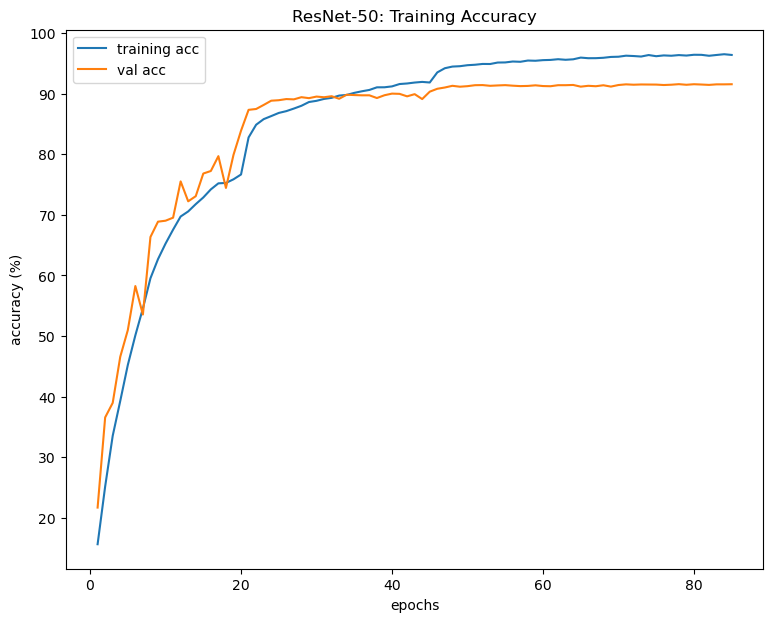

In [21]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['acc'] for k in training_history_lr_scheduler.keys()], label = 'training acc')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_acc'] for k in training_history_lr_scheduler.keys()], label = 'val acc')
plt.title("ResNet-50: Training Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(loc = 'best')
plt.show()

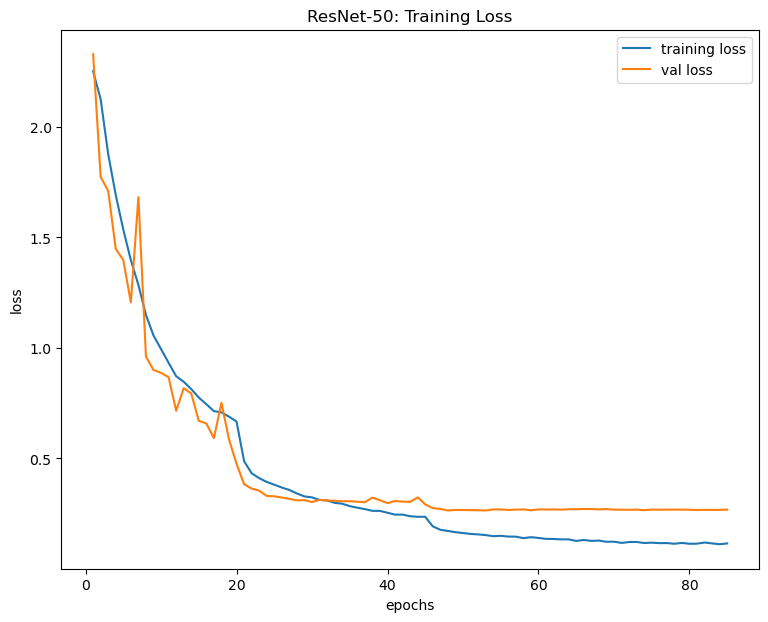

In [22]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['loss'] for k in training_history_lr_scheduler.keys()], label = 'training loss')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_loss'] for k in training_history_lr_scheduler.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("ResNet-50: Training Loss")
plt.show()

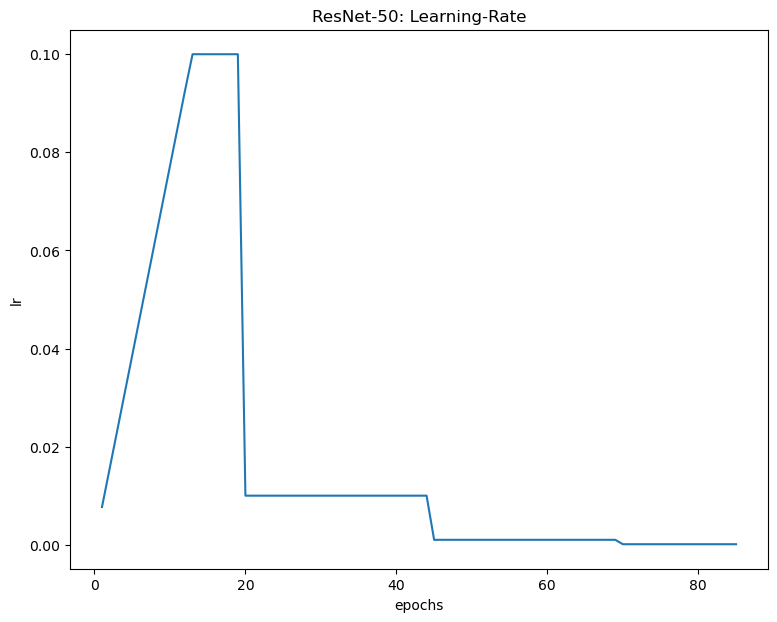

In [23]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['lr'] for k in training_history_lr_scheduler.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("ResNet-50: Learning-Rate")
plt.show()

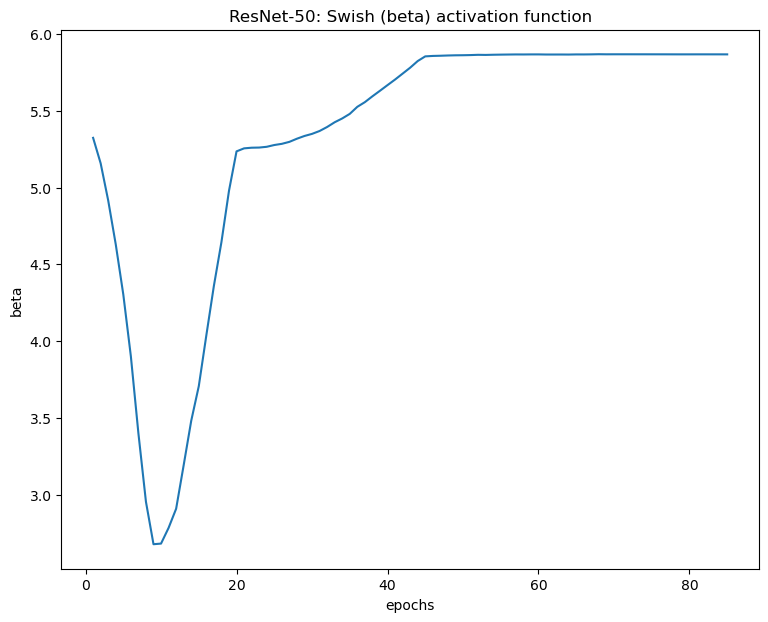

In [24]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['beta'] for k in training_history_lr_scheduler.keys()])
plt.xlabel("epochs")
plt.ylabel("beta")
plt.title("ResNet-50: Swish (beta) activation function")
plt.show()

In [25]:
# max([train_history[k]['val_acc'] for k in train_history.keys()])
max_val_acc = 0
max_epoch = 0

for e in training_history_lr_scheduler.keys():
    if training_history_lr_scheduler[e]['val_acc'] > max_val_acc:
        max_val_acc = training_history_lr_scheduler[e]['val_acc']
        max_epoch = e

print(f"highest val acc = {training_history_lr_scheduler[max_epoch]['val_acc']:.2f}%",
      f" is obtained for beta = {training_history_lr_scheduler[max_epoch]['beta']:.4f}"
)

highest val acc = 91.59%  is obtained for beta = 5.8668


In [ ]:
# Initialize and load 'best' trained parameters from above-
best_model = ResNet50()
best_model.load_state_dict(torch.load("ResNet50_best_valacc_model.pth"))

# Move to GPU device-
best_model.to(device)

In [29]:
# Get validation metrics of 'best' trained model-
val_loss, val_acc = test_model_progress(
    model = best_model, test_loader = val_loader,
    test_dataset = val_dataset
)

print("ResNet-50 'best' trained validation metrics: ",
      f"loss = {val_loss:.4f} & acc = {val_acc:.2f}%"
)

Validation: : 100%|████████████████████████████████| 40/40 [00:04<00:00,  9.32batch/s, val_acc=91.6, val_loss=0.268]

ResNet-50 'best' trained validation metrics:  loss = 0.2683 & acc = 91.59%
